## Figure 3: NaRRS Evaluation

In this notebook we will compare the Sentinel-3 NaRRS method/products with snow and ice thickness data from airborne campaigns and upward-looking sonar (ULS) moorings, producing Figure 3 from the manuscript.

Cross-validation (cv) results for the NaRRS method (passive + active microwave features) against Operation IceBridge (OIB) data are presented. Alongside, the cv results using only the gradient ratio (GR) to retireve snow depth are presented for intercomparison.

Snow depths and sea ice thicknesses from the resulting NaRRS product are compared with those retrieved from the AWI IceBird airborne campaigns. Draft, calculated as the difference between the retrieved sea ice thickness and ice freeboard, is compared with ULS mooring data from the Beaufort Gyre Exploration Project (BGEP) and the Fram Strait Arctic Outflow Observatory (AOO). 

**Data required**

Preprocessing and co-location steps applied to each dataset for each comparison are described in the manuscript. Unified datasets containing the S3 and external estimates were produced for each comparison and can be found in the NaRRS/Data directory as follows:
* Cross-validation results (S3/OIB): each fold results is stored as a .npz file in the directory NaRRS/Data/cv_fold_results/multilinear/ for the GR, LEW, and TED model, and NaRRS/Data/cv_fold_results/linear/ for the GR-only model. A csv file containing the validation statistics computed for each fold can also be found in these directories.
* S3/IceBird: NaRRS/Data/merged_s3_icebird_gridded_evaluation_data.csv
* S3/BGEP: NaRRS/Data/merged_s3_bgep_evaluation_data.csv
* S3/AOO: NaRRS/Data/merged_s3_aoo_evaluation_data.csv

The original comparison datasets can be found at:
* OIB: https://nsidc.org/data/nsidc-0708/versions/1
* IceBird: https://doi.pangaea.de/10.1594/PANGAEA.966009 and https://doi.pangaea.de/10.1594/PANGAEA.966057
* BGEP: https://www2.whoi.edu/site/beaufortgyre/data/
* AOO: https://data.npolar.no/dataset/5b717274-2d85-4f13-a1b4-ff0517c78b4a

The NaRRS product can be downloaded from https://www.cpom.ucl.ac.uk/narss


1) Import required packages

In [9]:
import sys
sys.path.append('/home/cn/NaRRS')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

2) Define functions

In [10]:
def calculate_prediction_metrics(y_true, y_pred):
    """Calculate various prediction metrics between true and predicted values.
    Parameters:
    y_true (array-like): True values.
    y_pred (array-like): Predicted values.
    
    Returns:
    tuple: A tuple containing RMSE, R², MAE, Pearson correlation coefficient (r), bias, and count of valid samples.
    """
    
    #create a nan mask for the predictions
    mask = np.isnan(y_pred) | np.isnan(y_true)
    y_true = y_true[~mask]
    y_pred = y_pred[~mask]
    
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r = np.corrcoef(y_true, y_pred.flatten())[0,1]
    bias = np.mean(y_pred.flatten() - y_true)
    count = int(len(y_true))
    return rmse, r2, mae, r, bias, count

3) Load the cross-validation results and fold prediction metrics dataset

In [11]:
#stats and results for the multi-linear ridge model (GR, LEW, TED)
cv_stats_df = pd.read_csv('../Data/cv_fold_results/multilinear/s3_oib_ridge_regression_kfold_results_stats.csv')
fold_results = {}
for fold in range(1,6):
    fold_results[fold] = np.load(f'../Data/cv_fold_results/multilinear/s3_oib_ridge_regression_fold_{fold}_predictions.npz')
    
#stats and results for the simple linear model (GR only)
linear_cv_stats_df = pd.read_csv('../Data/cv_fold_results/linear/s3_oib_gr_lin_regression_kfold_results_stats.csv')
linear_fold_results = {}
for fold in range(1,6):
    linear_fold_results[fold] = np.load(f'../Data/cv_fold_results/linear/s3_oib_gr_lin_regression_fold_{fold}_predictions.npz')

4) Load the S3 NaRSS vs. IceBird comparison dataset and compute the evaluation metrics

In [12]:
icebird_df = pd.read_csv('../Data/merged_s3_icebird_gridded_evaluation_data.csv')
icebird_df = icebird_df.rename(columns={'EsEs': 'cice_thickness'})
icebird_df['i'] = np.arange(len(icebird_df)) #add an index column for creating a color scheme later


#calculate the snow depth and sea ice thickness evaluation metrics against IceBird
icebird_s3_snod_metrics = calculate_prediction_metrics(icebird_df['snow_thickness'].values, icebird_df['snow_depth_01'].values)
icebird_s3_sit_metrics = calculate_prediction_metrics(icebird_df['cice_thickness'].values, icebird_df['sea_ice_thickness_01'].values)

icebird_mw99_snod_metrics = calculate_prediction_metrics(icebird_df['snow_thickness'].values, icebird_df['mwarren_snow_depth_01'].values)
icebird_mw99_sit_metrics = calculate_prediction_metrics(icebird_df['cice_thickness'].values, icebird_df['mwarren_sea_ice_thickness_01'].values)

icebird_metrics_df = pd.DataFrame({
    'metric': ['rmse', 'r2', 'mae', 'r', 'bias', 'count'],
    's3_snod': icebird_s3_snod_metrics,
    's3_sit': icebird_s3_sit_metrics,
    'mw99_snod': icebird_mw99_snod_metrics,
    'mw99_sit': icebird_mw99_sit_metrics
})

5) Load the S3 NaRRS vs. BGEP comparison dataset and compute the evaluation metrics

In [13]:
bgep_df = pd.read_csv('../Data/merged_s3_bgep_evaluation_data.csv')

#calculate the draft evaluation metrics against BGEP
bgep_s3_draft_metrics = calculate_prediction_metrics(bgep_df['mean_draft_rolling_mean'].values, bgep_df['ice_draft_01_mean_rolling_mean'].values)
bgep_mw99_draft_metrics = calculate_prediction_metrics(bgep_df['mean_draft_rolling_mean'].values, bgep_df['ice_draft_mwarren_01_mean_rolling_mean'].values)
bgep_metrics_df = pd.DataFrame({
    'metric': ['rmse', 'r2', 'mae', 'r', 'bias', 'count'],
    's3_draft': bgep_s3_draft_metrics,
    'mw99_draft': bgep_mw99_draft_metrics
})  

6) Load the S3 NaRRS vs. AOO comparison dataset and compute the evaluation metrics

In [14]:
aoo_df = pd.read_csv('../Data/merged_s3_aoo_evaluation_data.csv')

#calculate the draft evaluation metrics against AOO
aoo_s3_draft_metrics = calculate_prediction_metrics(aoo_df['draft'].values, aoo_df['ice_draft_01'].values)
aoo_mw99_draft_metrics = calculate_prediction_metrics(aoo_df['draft'].values, aoo_df['ice_draft_mwarren_01'].values)
aoo_metrics_df = pd.DataFrame({
    'metric': ['rmse', 'r2', 'mae', 'r', 'bias', 'count'],
    's3_draft': aoo_s3_draft_metrics,
    'mw99_draft': aoo_mw99_draft_metrics
})

7) Create Figure 3, visualizing the comparisons are scatter plots. We'll include the evaluation metrics as text in each panel

/tmp/ipykernel_2984106/2350612269.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10_r', len(fold_results))
/tmp/ipykernel_2984106/2350612269.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10_r', len(linear_fold_results))


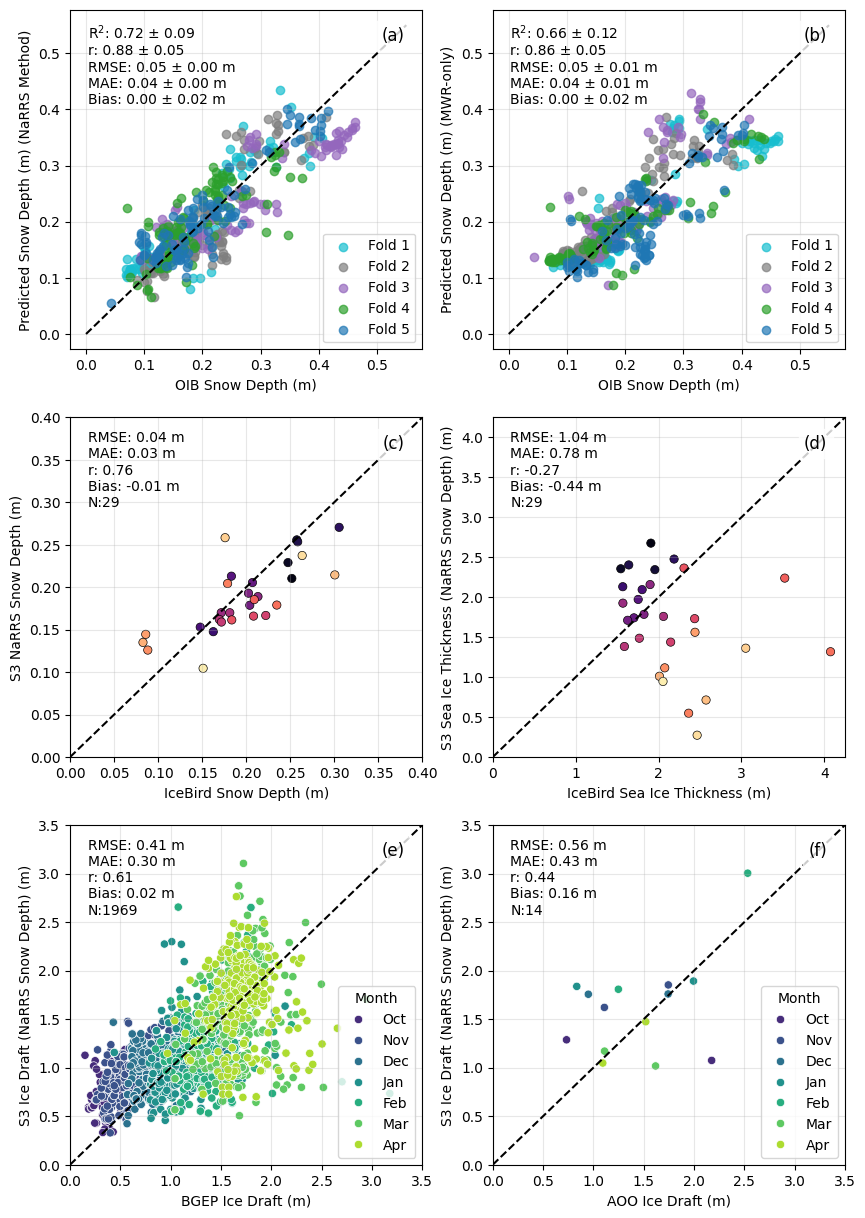

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15), gridspec_kw={'hspace': 0.2})
#top row: OIB cross-validation results
#lhs: NaRRS method (multi-linear ridge regression with GR, LEW, TED features)
ax = axs[0, 0]
ax.grid(True, alpha=0.3)
cmap = plt.cm.get_cmap('tab10_r', len(fold_results))
for fold, data in fold_results.items():
    ax.scatter(data['y_test'], data['y_pred'], label=f'Fold {fold}', alpha=0.7, color=cmap(fold - 1))
ax.plot([0, 0.55], [0, 0.55], color='black', linestyle='--')
ax.set_xlabel('OIB Snow Depth (m)')
ax.set_ylabel('Predicted Snow Depth (m) (NaRRS Method)')
ax.legend(loc='lower right')
ax.text(0.05, 0.96, f'R$^2$: {cv_stats_df["R2"].mean():.2f} ± {cv_stats_df["R2"].std():.2f}\n'
        f'r: {cv_stats_df["r"].mean():.2f} ± {cv_stats_df["r"].std():.2f}\n'
        f'RMSE: {cv_stats_df["RMSE"].mean():.2f} ± {cv_stats_df["RMSE"].std():.2f} m\n'
        f'MAE: {cv_stats_df["MAE"].mean():.2f} ± {cv_stats_df["MAE"].std():.2f} m\n'
        f'Bias: {cv_stats_df["Bias"].mean():.2f} ± {cv_stats_df["Bias"].std():.2f} m', transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.text(0.95, 0.95, '(a)', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
#rhs: GR-only linear regression
ax = axs[0, 1]
ax.grid(True, alpha=0.3)
cmap = plt.cm.get_cmap('tab10_r', len(linear_fold_results))
for fold, data in linear_fold_results.items():
    ax.scatter(data['y_test'], data['y_pred'], label=f'Fold {fold}', alpha=0.7, color=cmap(fold - 1))
ax.plot([0, 0.55], [0, 0.55], color='black', linestyle='--')
ax.set_xlabel('OIB Snow Depth (m)')
ax.set_ylabel('Predicted Snow Depth (m) (MWR-only)')
ax.legend(loc='lower right')
ax.text(0.05, 0.96, f'R$^2$: {linear_cv_stats_df["R2"].mean():.2f} ± {linear_cv_stats_df["R2"].std():.2f}\n'
        f'r: {linear_cv_stats_df["r"].mean():.2f} ± {linear_cv_stats_df["r"].std():.2f}\n'
        f'RMSE: {linear_cv_stats_df["RMSE"].mean():.2f} ± {linear_cv_stats_df["RMSE"].std():.2f} m\n'
        f'MAE: {linear_cv_stats_df["MAE"].mean():.2f} ± {linear_cv_stats_df["MAE"].std():.2f} m\n'
        f'Bias: {linear_cv_stats_df["Bias"].mean():.2f} ± {linear_cv_stats_df["Bias"].std():.2f} m', transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.text(0.95, 0.95, '(b)', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

#second row: IceBird vs S3 NaRRS snow depth and sea ice thickness
#lhs: snow depth
ax = axs[1, 0]
ax.grid(True, alpha=0.3)
sns.scatterplot(data=icebird_df, y='snow_depth_01', x='snow_thickness', ax=ax, hue='i', palette=sns.color_palette("magma", len(icebird_df)), legend=False, ec='black')
ax.set_xlabel('IceBird Snow Depth (m)')
ax.set_ylabel('S3 NaRRS Snow Depth (m)')
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.text(0.05, 0.96, f"RMSE: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'rmse', 's3_snod'].values[0]:.2f} m\n"
                     f"MAE: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'mae', 's3_snod'].values[0]:.2f} m\n"
                     f"r: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'r', 's3_snod'].values[0]:.2f}\n"
                     f"Bias: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'bias', 's3_snod'].values[0]:.2f} m\n"
                     f"N:{int(icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'count', 's3_snod'].values[0])}",
                      transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.set_xlim(0, 0.4)
ax.set_ylim(0, 0.4)
ax.text(0.95, 0.95, '(c)', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
#rhs: sea ice thickness
ax = axs[1, 1]
ax.grid(True, alpha=0.3)
sns.scatterplot(data=icebird_df, y='sea_ice_thickness_01', x='cice_thickness', ax=ax, hue='i', palette=sns.color_palette("magma", len(icebird_df)), legend=False, ec='black')
ax.set_xlabel('IceBird Sea Ice Thickness (m)')
ax.set_ylabel('S3 Sea Ice Thickness (NaRRS Snow Depth) (m)')
ax.plot([0, 4.25], [0, 4.25], 'k--')
ax.text(0.05, 0.96, f"RMSE: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'rmse', 's3_sit'].values[0]:.2f} m\n"
                  f"MAE: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'mae', 's3_sit'].values[0]:.2f} m\n"
                  f"r: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'r', 's3_sit'].values[0]:.2f}\n"
                  f"Bias: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'bias', 's3_sit'].values[0]:.2f} m\n"
                  f"N:{int(icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'count', 's3_sit'].values[0])}",
                  transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.set_xlim(0, 4.25)
ax.set_ylim(0, 4.25)
ax.text(0.95, 0.95, '(d)', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

#bottom row: BGEP and AOO vs S3 NaRRS ice draft
#lhs: BGEP vs S3 ice draft
ax = axs[2, 0]
ax.grid(True, alpha=0.3)
sns.scatterplot(data=bgep_df, x='mean_draft_rolling_mean', y='ice_draft_01_mean_rolling_mean', ax=ax, hue='Month', palette='viridis')
ax.set_xlabel('BGEP Ice Draft (m)')
ax.set_ylabel('S3 Ice Draft (NaRRS Snow Depth) (m)')
ax.plot([0, 5], [0, 5], 'k--')
ax.text(0.05, 0.96, f"RMSE: {bgep_metrics_df.loc[bgep_metrics_df['metric'] == 'rmse', 's3_draft'].values[0]:.2f} m\n"
                    f"MAE: {bgep_metrics_df.loc[bgep_metrics_df['metric'] == 'mae', 's3_draft'].values[0]:.2f} m\n"
                    f"r: {bgep_metrics_df.loc[bgep_metrics_df['metric'] == 'r', 's3_draft'].values[0]:.2f}\n"
                    f"Bias: {bgep_metrics_df.loc[bgep_metrics_df['metric'] == 'bias', 's3_draft'].values[0]:.2f} m\n"
                    f"N:{int(bgep_metrics_df.loc[bgep_metrics_df['metric'] == 'count', 's3_draft'].values[0])}",
                    transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.set_xlim(0, 3.5)
ax.set_ylim(0, 3.5)
sns.move_legend(ax, "lower right")
ax.text(0.95, 0.95, '(e)', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
#rhs: AOO vs S3 ice draft
ax = axs[2, 1]
ax.grid(True, alpha=0.3)
sns.scatterplot(data=aoo_df, x='draft', y='ice_draft_01', ax=ax, hue='Month', palette='viridis')
ax.set_xlabel('AOO Ice Draft (m)')
ax.set_ylabel('S3 Ice Draft (NaRRS Snow Depth) (m)')
ax.plot([0, 4], [0, 4], 'k--')
ax.text(0.05, 0.96, f"RMSE: {aoo_metrics_df.loc[aoo_metrics_df['metric'] == 'rmse', 's3_draft'].values[0]:.2f} m\n"
                    f"MAE: {aoo_metrics_df.loc[aoo_metrics_df['metric'] == 'mae', 's3_draft'].values[0]:.2f} m\n"
                    f"r: {aoo_metrics_df.loc[aoo_metrics_df['metric'] == 'r', 's3_draft'].values[0]:.2f}\n"
                    f"Bias: {aoo_metrics_df.loc[aoo_metrics_df['metric'] == 'bias', 's3_draft'].values[0]:.2f} m\n"
                    f"N:{int(aoo_metrics_df.loc[aoo_metrics_df['metric'] == 'count', 's3_draft'].values[0])}",
                    transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.set_xlim(0, 3.5)
ax.set_ylim(0, 3.5)
sns.move_legend(ax, "lower right")
ax.text(0.95, 0.95, '(f)', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

plt.savefig('s3_snow_depth_and_sea_ice_thickness_multisource_evaluation.png', bbox_inches='tight', dpi=300)
plt.show()


## Supplementary Figure

Here, we make the same comparisons except we use the modified Warren Climatology (mW99) in place of the NaRRS snow depth as a reference/to intercompare.

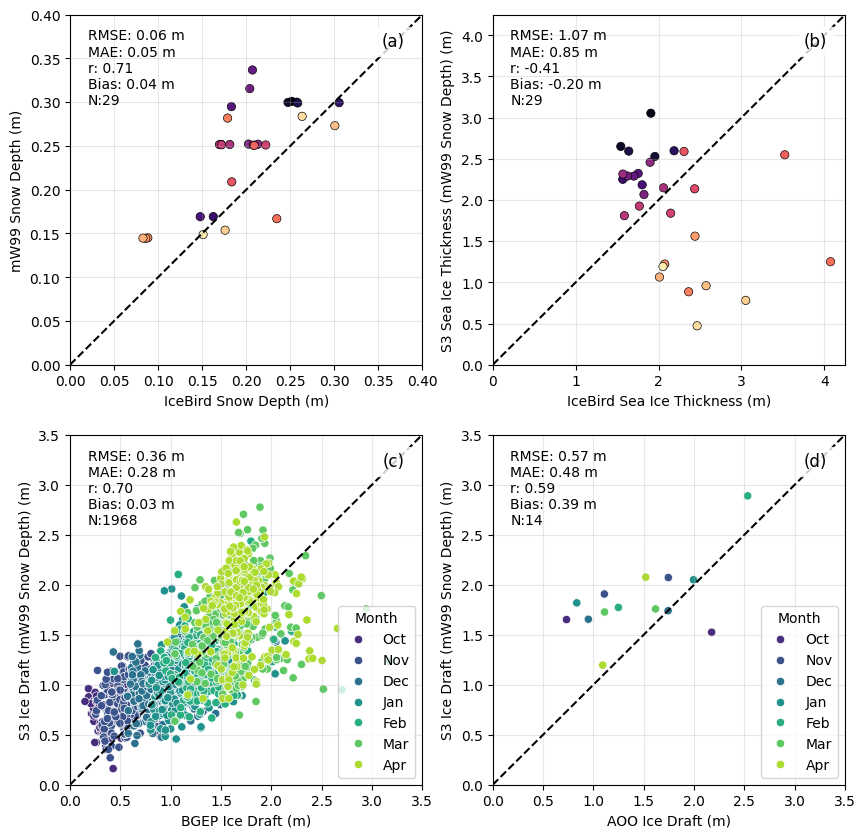

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'hspace': 0.2})

#top row: IceBird vs mW99 snow depth and S3-mW99 sea ice thickness
#lhs: snow depth
ax = axs[0, 0]
ax.grid(True, alpha=0.3)
sns.scatterplot(data=icebird_df, y='mwarren_snow_depth_01', x='snow_thickness', ax=ax, hue='i', palette=sns.color_palette("magma", len(icebird_df)), legend=False, ec='black')
ax.set_xlabel('IceBird Snow Depth (m)')
ax.set_ylabel('mW99 Snow Depth (m)')
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.text(0.05, 0.96, f"RMSE: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'rmse', 'mw99_snod'].values[0]:.2f} m\n"
                     f"MAE: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'mae', 'mw99_snod'].values[0]:.2f} m\n"
                     f"r: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'r', 'mw99_snod'].values[0]:.2f}\n"
                     f"Bias: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'bias', 'mw99_snod'].values[0]:.2f} m\n"
                     f"N:{int(icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'count', 'mw99_snod'].values[0])}",
                      transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.set_xlim(0, 0.4)
ax.set_ylim(0, 0.4)
ax.text(0.95, 0.95, '(a)', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
#rhs: sea ice thickness
ax = axs[0, 1]
ax.grid(True, alpha=0.3)
sns.scatterplot(data=icebird_df, y='mwarren_sea_ice_thickness_01', x='cice_thickness', ax=ax, hue='i', palette=sns.color_palette("magma", len(icebird_df)), legend=False, ec='black')
ax.set_xlabel('IceBird Sea Ice Thickness (m)')
ax.set_ylabel('S3 Sea Ice Thickness (mW99 Snow Depth) (m)')
ax.plot([0, 4.25], [0, 4.25], 'k--')
ax.text(0.05, 0.96, f"RMSE: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'rmse', 'mw99_sit'].values[0]:.2f} m\n"
                  f"MAE: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'mae', 'mw99_sit'].values[0]:.2f} m\n"
                  f"r: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'r', 'mw99_sit'].values[0]:.2f}\n"
                  f"Bias: {icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'bias', 'mw99_sit'].values[0]:.2f} m\n"
                  f"N:{int(icebird_metrics_df.loc[icebird_metrics_df['metric'] == 'count', 'mw99_sit'].values[0])}",
                  transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.set_xlim(0, 4.25)
ax.set_ylim(0, 4.25)
ax.text(0.95, 0.95, '(b)', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

#bottom row: BGEP and AOO vs S3 mW99 ice draft
#lhs: BGEP vs S3 mW99 ice draft
ax = axs[1, 0]
ax.grid(True, alpha=0.3)
sns.scatterplot(data=bgep_df, x='mean_draft_rolling_mean', y='ice_draft_mwarren_01_mean_rolling_mean', ax=ax, hue='Month', palette='viridis')
ax.set_xlabel('BGEP Ice Draft (m)')
ax.set_ylabel('S3 Ice Draft (mW99 Snow Depth) (m)')
ax.plot([0, 5], [0, 5], 'k--')
ax.text(0.05, 0.96, f"RMSE: {bgep_metrics_df.loc[bgep_metrics_df['metric'] == 'rmse', 'mw99_draft'].values[0]:.2f} m\n"
                    f"MAE: {bgep_metrics_df.loc[bgep_metrics_df['metric'] == 'mae', 'mw99_draft'].values[0]:.2f} m\n"
                    f"r: {bgep_metrics_df.loc[bgep_metrics_df['metric'] == 'r', 'mw99_draft'].values[0]:.2f}\n"
                    f"Bias: {bgep_metrics_df.loc[bgep_metrics_df['metric'] == 'bias', 'mw99_draft'].values[0]:.2f} m\n"
                    f"N:{int(bgep_metrics_df.loc[bgep_metrics_df['metric'] == 'count', 'mw99_draft'].values[0])}",
                    transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.set_xlim(0, 3.5)
ax.set_ylim(0, 3.5)
sns.move_legend(ax, "lower right")
ax.text(0.95, 0.95, '(c)', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
#rhs: AOO vs S3 mW99 ice draft
ax = axs[1, 1]
ax.grid(True, alpha=0.3)
sns.scatterplot(data=aoo_df, x='draft', y='ice_draft_mwarren_01', ax=ax, hue='Month', palette='viridis')
ax.set_xlabel('AOO Ice Draft (m)')
ax.set_ylabel('S3 Ice Draft (mW99 Snow Depth) (m)')
ax.plot([0, 4], [0, 4], 'k--')
ax.text(0.05, 0.96, f"RMSE: {aoo_metrics_df.loc[aoo_metrics_df['metric'] == 'rmse', 'mw99_draft'].values[0]:.2f} m\n"
                    f"MAE: {aoo_metrics_df.loc[aoo_metrics_df['metric'] == 'mae', 'mw99_draft'].values[0]:.2f} m\n"
                    f"r: {aoo_metrics_df.loc[aoo_metrics_df['metric'] == 'r', 'mw99_draft'].values[0]:.2f}\n"
                    f"Bias: {aoo_metrics_df.loc[aoo_metrics_df['metric'] == 'bias', 'mw99_draft'].values[0]:.2f} m\n"
                    f"N:{int(aoo_metrics_df.loc[aoo_metrics_df['metric'] == 'count', 'mw99_draft'].values[0])}",
                    transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.set_xlim(0, 3.5)
ax.set_ylim(0, 3.5)
sns.move_legend(ax, "lower right")
ax.text(0.95, 0.95, '(d)', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

plt.savefig('../Manuscript_Supplementary_Figures/mW99_snow_depth_and_sea_ice_thickness_multisource_evaluation.png', bbox_inches='tight', dpi=300)
plt.show()